# https://www.youtube.com/watch?v=CtwJvgPJ9xw

Noah version of exploring, I'm going to make a faux pytorch model for some of the essential part of this project, i.e. the autoencoder for unsupervised pre-training, and the same for labelled data files.

In [1]:
import os
import random

import numpy as np
import pandas as pd
import pytorch_lightning as pl

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

# 1. Load in data

In [2]:
## Neccessary imports


# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../dat/data/'
annotation_csv = image_folder + 'annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

transform = torchvision.transforms.ToTensor()


In [3]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.
labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )



labeled_trainset = LabeledDataset(image_folder=image_folder,
annotation_file=annotation_csv,
scene_index=labeled_scene_index,
transform=transform,
extra_info=True
)


labeled_trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=3, 
                                                  shuffle=True, num_workers=2, collate_fn=collate_fn)


unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=labeled_scene_index, 
                                      first_dim='sample', transform=transform)
unlabeled_trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=3, 
                                                    shuffle=True, num_workers=2)

In [4]:
sample, target, road_image, extra = iter(labeled_trainloader).next()
#each of these is a tuple, for the batch size. 

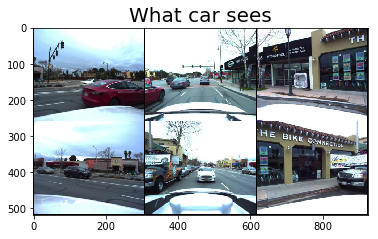

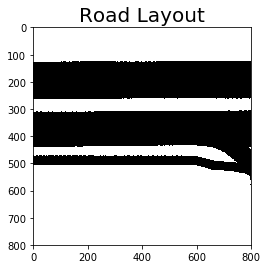

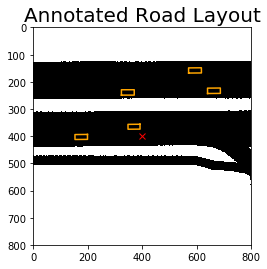

In [5]:
plt.figure()
plt.title("What car sees", fontsize = 20)
plt.imshow(torchvision.utils.make_grid(sample[1], nrow=3).numpy().transpose(1, 2, 0))

plt.figure()
plt.title("Road Layout", fontsize = 20)

plt.imshow(road_image[0],cmap = 'binary')

fig, ax = plt.subplots()
plt.title("Annotated Road Layout",fontsize = 20)

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    


# 2. How it's iterated through (necessary for training)

### 2.1 Unlabeled iterator (pretend I'm training an autoencoder)

In [6]:
for image in unlabeled_trainloader: #no camera index, weird. It is implied by channels, though. 
    break 
    
    # print(torch.stack(sample).shape)
    image_pred = autoencoder(image)
    
    loss = F.mse(image_pred,image)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

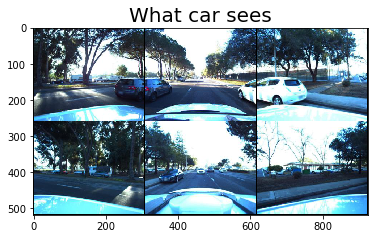

In [7]:
plt.figure()
plt.title("What car sees", fontsize = 20)
plt.imshow(torchvision.utils.make_grid(image[0], nrow=3).numpy().transpose(1, 2, 0))

## 2.2 Labeled iterator

In [8]:
for sample, target, road_image, extra in labeled_trainloader:
    
    sample = torch.stack(sample) #probably good practice to straight up rename, preserves memory. 
    road_image = torch.stack(road_image)
    break
    
    #And if this was a training thing . . .
    
    predicted_layout = model(sample)
    
    loss = F.bce_loss(predicted_layout,road_image)  ### Double check this! Make sure input =  prediction vs target, etc. 
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()

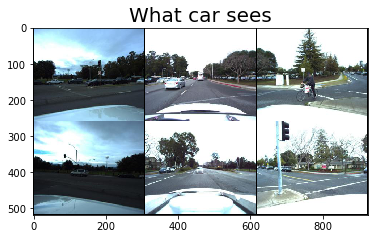

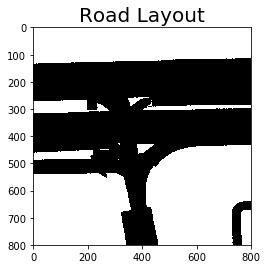

In [9]:
plt.figure()
plt.title("What car sees", fontsize = 20)
plt.imshow(torchvision.utils.make_grid(sample[0], nrow=3).numpy().transpose(1, 2, 0))
plt.figure()
plt.title("Road Layout", fontsize = 20)

plt.imshow(road_image[0],cmap = 'binary')


# And that's a wrap for now. 


## The biggest stuff to hit: What model works best at doing this task. In particular, find the best autoencoder, and start here. Use that to create the ideal $z$ which works in creating a road layout. 

## Data augmentations? What makes it even more obvious this is a road for instance. 


## Not even TOUCHING bounding box yet, but tbh task-wise, that might be easier! Differentiating between a car and a person is a well studied problem

# Note: Channel-wise version might suck. Why should they do that, they are independent representations, so have each trained differently?

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
device

In [ ]:
class Conv_Autoencoder(nn.Module):
    """
    Convolutional autoencoder. Learns the best possible latent representation of the 6 channel input image of the car cameras.
    """
    
    
    def forward(x):
        
        return x
    
    
    
class Latent_Mapper(nn.Module):
    """
    Given z (which does not pass any more info back) take this latent and hopefully representative input to 
    more effectievely generate a road layout. 
    """
    #this should be in it somewhere, idk. 
    try:
        z = z.detach()
    except:
        pass 
    
    
    

In [11]:
sample.shape

torch.Size([3, 6, 3, 256, 306])

## Lightning models -- based on above

In [ ]:

def conv3x3x3(inplane, outplane, stride=1,padding=0):
    """
    Simple 3x3x3 convolutional block. Maybe I'll update it's name and break everything :-) 
    """
    return nn.Conv3d(inplane,outplane,kernel_size=3,stride=stride,padding=padding,bias=True)

class BasicBlock(nn.Module):
    """
    Basic convolutional block used for all non-dense blocks in my network. Specifically, this is the downsampling layer and bottleneck layers. 
    Since the bottleneck layer is better suited for dropout, I include the optional choice for either here, with a preset dropout val of 0.5.
    """
    def __init__(self,inplane,outplane,stride = 1,padding = 1, batchnorm=True,dropout=False):
        super(BasicBlock, self).__init__()
        self.padding = padding
        self.conv1 = conv3x3x3(inplane,outplane,padding=padding,stride=stride)
        self.batchnorm = batchnorm
        self.dropout = dropout
        self.bn1 = nn.BatchNorm3d(outplane)
        self.dropout1 = nn.Dropout3d(p=0.5)
        self.relu = nn.ReLU(inplace=True)

    def forward(self,x):
        out = self.conv1(x)
        out = self.relu(out)
        if self.batchnorm:
            out = self.bn1(out)
        if self.dropout:
            out = self.dropout1(out)
        
        return out


    
class Conv_Autoencoder(nn.Module):
    """
    Convolutional autoencoder, designed to form a smaller representation of these car images. 
    
    Currently, an input is 6 images, each of shape 356x306x3, or 6x3x256x306 in python shape. 
    
    My initial idea in this case is to make them separated out , bottleneck, and out. 
    
    
    
    """
    def __init__(self,in_ch,out_ch):
        super(Conv_Autoencoder,self).__init__()
        
        #down 3, 
        #this should be a block, not 1, but let's do 1 for now 
        self.conv1a = nn.Conv2d(in_channels = in_ch,out_channels=,kernel_size = 3,)
        self.conv1b =  nn.Conv2d(in_channels = in_ch,out_channels=)
        # go up to f. 
        
        
        self.downsample1a = nn.Conv2d(in_channels = ,out_channels = , stride = 2) # or dilation = 2!
        
        self.latent_space = nn.Conv2d() #output of down 1a and b
        
        
        
        å

class MNISTModel(pl.LightningModule):

    def __init__(self):
        super(MNISTModel, self).__init__()
        # not the best model...
        self.l1 = torch.nn.Linear(28 * 28, 10)

    def forward(self, x):
        # called with self(x)
        return torch.relu(self.l1(x.view(x.size(0), -1)))

    def training_step(self, batch, batch_nb):
        # REQUIRED
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        return {'val_loss': F.cross_entropy(y_hat, y)}

    def validation_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        # OPTIONAL
        x, y = batch
        y_hat = self(x)
        return {'test_loss': F.cross_entropy(y_hat, y)}

    def test_epoch_end(self, outputs):
        # OPTIONAL
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}
        return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs}

    def configure_optimizers(self):
        # REQUIRED
        # can return multiple optimizers and learning_rate schedulers
        # (LBFGS it is automatically supported, no need for closure function)
        return torch.optim.Adam(self.parameters(), lr=0.02)

    def train_dataloader(self):
        # REQUIRED
        return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

    def val_dataloader(self):
        # OPTIONAL
        return DataLoader(MNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor()), batch_size=32)

    def test_dataloader(self):
        # OPTIONAL
        return DataLoader(MNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor()), batch_size=32)